<a href="https://colab.research.google.com/github/avdhoot001/Machine_learning/blob/main/reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
from typing import Literal
import matplotlib.pyplot as plt
import PIL.Image as Image
from glob import glob

In [ ]:

import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
!wget https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip #training data

--2024-05-21 05:31:09--  https://xeek-public-287031953319-eb80.s3.amazonaws.com/stranger-sections-2/stranger-sections-2-train-data.zip
Resolving xeek-public-287031953319-eb80.s3.amazonaws.com (xeek-public-287031953319-eb80.s3.amazonaws.com)... 52.217.113.201, 54.231.236.9, 52.216.165.171, ...
Connecting to xeek-public-287031953319-eb80.s3.amazonaws.com (xeek-public-287031953319-eb80.s3.amazonaws.com)|52.217.113.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26029613 (25M) [application/zip]
Saving to: ‘stranger-sections-2-train-data.zip’

stranger-sections-2 100%[===================>]  24.82M  26.6MB/s    in 0.9s    

2024-05-21 05:31:10 (26.6 MB/s) - ‘stranger-sections-2-train-data.zip’ saved [26029613/26029613]



In [ ]:
!pip install patool
import patoolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 2.0 MB/s eta 0:00:00


In [ ]:
patoolib.extract_archive('/content/stranger-sections-2-train-data.zip')

INFO patool: Extracting /content/stranger-sections-2-train-data.zip ...
INFO:patool:Extracting /content/stranger-sections-2-train-data.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_f1slxtxs -- /content/stranger-sections-2-train-data.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_f1slxtxs -- /content/stranger-sections-2-train-data.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/stranger-sections-2-train-data.zip extracted to `stranger-sections-2-train-data' (multiple files in root).
INFO:patool:... /content/stranger-sections-2-train-data.zip extracted to `stranger-sections-2-train-data' (multiple files in root).


'stranger-sections-2-train-data'

In [ ]:
# https://youtu.be/XyX5HNuv-xE
# https://youtu.be/q-p8v1Bxvac
"""
Standard Unet
Model not compiled here, instead will be done externally to make it
easy to test various loss functions and optimizers.
"""


from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda




################################################################
def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model


In [ ]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


In [ ]:
#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=4 #Number of classes for segmentation

In [ ]:
os.makedirs("image_patches", exist_ok=True)
images = sorted(glob.glob('/content/stranger-sections-2-train-data/image/*'))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)

    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )

    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])


    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = 'im%03d.png'%(start_no + i)

        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/image_patches",imname))

    start_no = start_no + patches.shape[0]

100%|██████████| 87/87 [04:45<00:00,  3.28s/it]


In [ ]:
import shutil
shutil.rmtree("/content/label_patches")

In [ ]:
os.makedirs("label_patches", exist_ok=True)
labels = sorted(glob.glob('/content/stranger-sections-2-train-data/label/*'))
start_no = 0
i=0
for image2 in tqdm(labels):
    array = np.load(image2)
    if(i==0):
      print(array.shape)

    # Load the large image
    # large_image = tf.keras.preprocessing.image.load_img(image)
    # large_image = image
    # Convert the image to a tensor
    # large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = tf.convert_to_tensor(array)


# Check the type and shape of the tensor
    # print("Type of the tensor:", type(large_image))
    # print("Shape of the tensor:", large_image.shape)

    large_image = large_image[:,:,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname =  'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(os.path.join("/content/label_patches",imname))

    start_no = start_no + patches.shape[0]


  0%|          | 0/87 [00:00<?, ?it/s]

(1024, 1360)


100%|██████████| 87/87 [00:18<00:00,  4.83it/s]


In [ ]:
image = Image.open("/content/label_patches/im000.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape

(256, 256)

In [ ]:
image = Image.open("/content/image_patches/im4219.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape

(256, 256, 3)

In [ ]:
import glob
import os
import cv2
import numpy as np

# List to store images
train_images = []

# Directory containing image patches
directory_path = "/content/image_patches"

# Loop through all png images in the specified directory and subdirectories
for img_path in glob.glob(os.path.join(directory_path, "**", "*.png"), recursive=True):
    # Read the image in grayscale mode
    img = cv2.imread(img_path, 0)

    # Verify that the image is read as grayscale (should have 2 dimensions)
    if img is not None and len(img.shape) == 2:
        train_images.append(img)
    else:
        print(f"Error reading image or not a grayscale image: {img_path}")

# Convert list to array for machine learning processing
train_images = np.array(train_images)

# Verify the shape and type of the resulting array
print(f'Shape of train_images array: {train_images.shape}')
print(f'Data type of train_images array: {train_images.dtype}')


Shape of train_images array: (5481, 256, 256)
Data type of train_images array: uint8


In [ ]:
train_images = []
import glob

for directory_path in glob.glob("/content/image_patches"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        train_images.append(img)


#Convert list to array for machine learning processing
train_images = np.array(train_images)


In [ ]:
train_images.shape

(5481, 256, 256)

array([[ 71,  70,  71, ..., 208, 209, 210],
       [ 72,  71,  70, ..., 208, 210, 210],
       [ 70,  70,  69, ..., 209, 210, 211],
       ...,
       [205, 205, 205, ..., 212, 212, 211],
       [207, 207, 207, ..., 212, 212, 211],
       [206, 207, 207, ..., 212, 212, 211]], dtype=uint8)
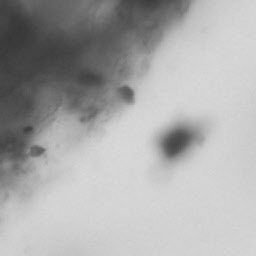

In [ ]:
train_images[5]

In [ ]:
train_masks = []
for directory_path in glob.glob("/content/label_patches"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        train_masks.append(mask)

#Convert list to array for machine learning processing
train_masks = np.array(train_masks)

In [ ]:
train_masks.shape


NameError: name 'train_masks' is not defined

In [ ]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

In [ ]:
train_images.shape

(5481, 256, 256, 1)

In [ ]:
train_masks_input = np.expand_dims(train_masks, axis=3)

In [ ]:
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)


In [ ]:

n_classes = 4
from keras.utils import to_categorical
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))



In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_masks_reshaped_encoded),
                                                 train_masks_reshaped_encoded)
print("Class weights are...:", class_weights)


NameError: name 'train_masks_reshaped_encoded' is not defined

In [ ]:

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


In [ ]:
def get_model():
    return multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
from google.colab import files
loading = files.upload()

In [ ]:
model.load_weights("/content/test(1).hdf5")

In [ ]:
model.save('test.hdf5')

In [ ]:
_, acc = model.evaluate(X_test, y_test_cat)
print("Accuracy is = ", (acc * 100.0), "%")


18/18 [==============================] - 9s 142ms/step - loss: 0.0954 - accuracy: 0.9787
Accuracy is =  97.86624908447266 %


In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

18/18 [==============================] - 1s 66ms/step


In [ ]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.8608296


[[1.6777216e+07 2.9029000e+04 1.0851100e+05 6.8189000e+04]
 [5.2763000e+04 7.1690600e+05 1.0459000e+04 0.0000000e+00]
 [4.4123900e+05 1.1700000e+02 2.2797490e+06 5.0000000e+00]
 [5.7400000e+04 0.0000000e+00 0.0000000e+00 4.9594100e+05]]
IoU for class1 is:  0.9568201
IoU for class2 is:  0.8858631
IoU for class3 is:  0.8027059
IoU for class4 is:  0.79792935


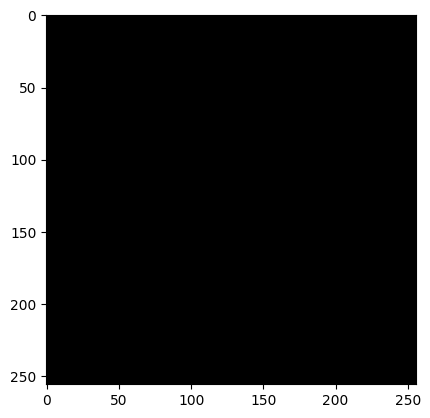

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

plt.imshow(train_images[0, :,:,0], cmap='gray')
plt.imshow(train_masks[0], cmap='gray')

1/1 [==============================] - 0s 47ms/step


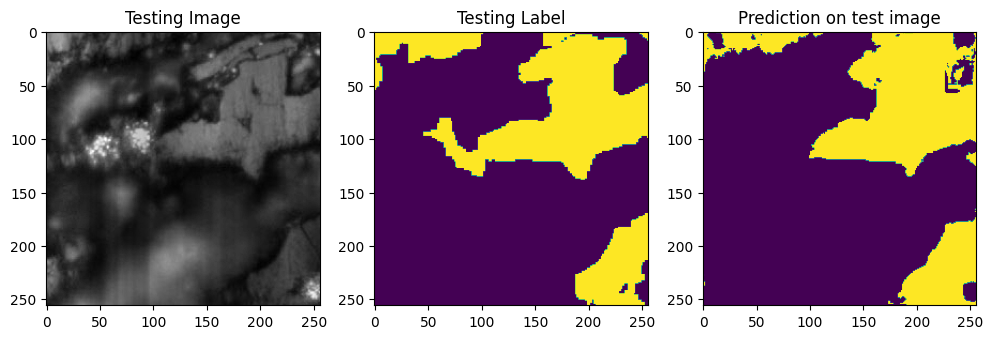

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

### ***from here starts the breaking of submission image and reconstruction script***

In [ ]:
#this is not used,ignore. just in case if the padding approach fails, i will use this
from PIL import Image
import numpy as np
import os

# Load the image
image = Image.open('/content/17gw5j.JPG')  # Replace with your image path

# Convert image to NumPy array
image_array = np.array(image)

# Get dimensions of the image
img_height, img_width = image_array.shape[:2]

# Patch size
patch_height = 256
patch_width = 256

# Step size (amount of overlap)
step_size = 128  # 50% overlap

# Create a directory to save patches if it doesn't exist
os.makedirs('patches', exist_ok=True)

# Initialize list to store patches
patches = []

# Divide the image into patches with overlap
patch_index = 0
for i in range(0, img_height - patch_height + 1, step_size):
    for j in range(0, img_width - patch_width + 1, step_size):
        patch = image_array[i:i + patch_height, j:j + patch_width]
        patches.append(patch)
        # Convert the patch to a PIL image and save it
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        print(f"{i}___{j}___{patch_index}")
        patch_index += 1

# Handling remaining bottom part if not fully covered
if (img_height - patch_height) % step_size != 0:
    for j in range(0, img_width - patch_width + 1, step_size):
        patch = image_array[-patch_height:, j:j + patch_width]
        patches.append(patch)
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        print("hehe1")
        print(f"{i}___{j}___{patch_index}")



        patch_index += 1

# Handling remaining right part if not fully covered
if (img_width - patch_width) % step_size != 0:
    for i in range(0, img_height - patch_height + 1, step_size):
        patch = image_array[i:i + patch_height, -patch_width:]
        patches.append(patch)
        patch_image = Image.fromarray(patch)
        patch_image.save(f'patches/patch_{patch_index}.png')
        print("hehe2")
        print(f"{i}___{j}___{patch_index}")

        patch_index += 1

# Handling bottom-right corner if not fully covered
if (img_height - patch_height) % step_size != 0 and (img_width - patch_width) % step_size != 0:
    patch = image_array[-patch_height:, -patch_width:]
    patches.append(patch)
    patch_image = Image.fromarray(patch)
    patch_image.save(f'patches/patch_{patch_index}.png')
    print("hehe3")


In [ ]:
from PIL import Image, ImageOps

os.mkdir("patches_with_padding")
# Load the original image
image = Image.open('/content/2fpvuk.JPG')
# image = Image.open('/content/stranger-sections-2-train-data/label/17gw5j_gt.npy')


# Original image dimensions
original_width, original_height = image.size

# New dimensions after padding
new_width = 1536
new_height = 1024

# Calculate padding
padding_left = (new_width - original_width) // 2
padding_right = padding_left
padding_top = 0
padding_bottom = 0

# Add padding to the image
padded_image = ImageOps.expand(image, (padding_left, padding_top, padding_right, padding_bottom))

# Dimensions of the padded image
padded_width, padded_height = padded_image.size

# Create patches
patch_size = 256
patches = []

for y in range(0, padded_height, patch_size):
    for x in range(0, padded_width, patch_size):
        box = (x, y, x + patch_size, y + patch_size)
        patch = padded_image.crop(box)
        patches.append(patch)

# Save patches or process further
for i, patch in enumerate(patches):
    patch.save(f'patches_with_padding/patch_{i+1}.png')

print(f'Total patches created: {len(patches)}')


Total patches created: 24


In [ ]:
import shutil
shutil.rmtree("/content/verify")

In [ ]:
import numpy as np
os.makedirs("/content/verify", exist_ok=True)
# Load the array from the .npy file
array = np.load('/content/stranger-sections-2-train-data/label/17gw5j_gt.npy')

# Original dimensions
height, width = array.shape

# Calculate padding values
padding_left = 88
padding_right = 88
padding_top = 0  # No padding required for height
padding_bottom = 0  # No padding required for height

# Pad the array
padded_array = np.pad(array,
                      ((padding_top, padding_bottom), (padding_left, padding_right)),
                      mode='constant', constant_values=0)

# Print the shape of the padded array
print(f"Padded array shape: {padded_array.shape}")
def break_into_patches(array, patch_size):
    m=0
    patches = []
    padded_height, padded_width = array.shape

    for i in range(0, padded_height, patch_size):
        for j in range(0, padded_width, patch_size):
            patch = array[i:i+patch_size, j:j+patch_size]
            np.save(f"/content/verify/p{m}",patch)
            patches.append(patch)
            print(f"{i}__{j}")
            m+=1

    return np.array(patches)

# Define patch size
patch_size = 256

# Get the patches
patches = break_into_patches(padded_array, patch_size)

# Print the number of patches and shape of each patch
print(f"Number of patches: {len(patches)}")
print(f"Shape of each patch: {patches[0].shape}")




Padded array shape: (1024, 1536)
0__0
0__256
0__512
0__768
0__1024
0__1280
256__0
256__256
256__512
256__768
256__1024
256__1280
512__0
512__256
512__512
512__768
512__1024
512__1280
768__0
768__256
768__512
768__768
768__1024
768__1280
Number of patches: 24
Shape of each patch: (256, 256)


In [ ]:
test_patches = []
import glob

for directory_path in glob.glob("/content/patches_with_padding"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 1)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        test_patches.append(img)

#Convert list to array for machine learning processing
test_patches = np.array(test_patches)

In [ ]:
test_patches.shape

(24, 256, 256, 3)

In [ ]:
len(test_patches)

24

In [ ]:
import numpy as np
import os

# Create a directory to save the .npy files if it doesn't exist
os.makedirs('saved_arrays', exist_ok=True)

for i in range(10):  # Example loop, adjust range as needed
    # Create a sample array (replace with your actual array)
    array = np.random.rand(256, 256)

    # Define the filename with the current iteration number
    filename = f'saved_arrays/array_{i}.npy'

    # Save the array as an .npy file
    np.save(filename, array)

    print(f'Saved {filename}')


(256, 256, 3)
1/1 [==============================] - 0s 161ms/step


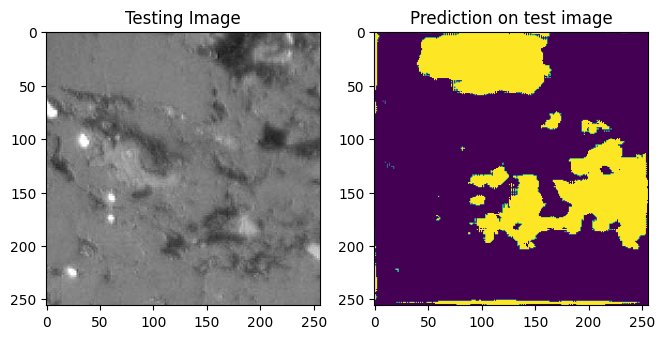

In [ ]:
import random
test_patch_number = random.randint(0, len(test_patches))
test_img = test_patches[test_patch_number]
# image = Image.open("/content/patches/patch_3.png")
# test_img = np.array(image)
print(test_img.shape)
# ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
# plt.title('Testing Label')
# plt.imshow(ground_truth[:,:,0])
# plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
os.makedirs("segmented_patches", exist_ok=True)


for test_patch_number in range(0,24):
  test_img = test_patches[test_patch_number]
  # image = Image.open("/content/patches/patch_3.png")
  # test_img = np.array(image)
  print(test_img.shape)
  # ground_truth=y_test[test_img_number]
  test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img_norm, 0)
  prediction = (model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  filename = os.path.join("/content/segmented_patches", f'seg_patch{test_patch_number}')

  np.save(filename, predicted_img)


(256, 256, 3)
1/1 [==============================] - 0s 461ms/step
(256, 256, 3)
1/1 [==============================] - 0s 456ms/step
(256, 256, 3)
1/1 [==============================] - 1s 678ms/step
(256, 256, 3)
1/1 [==============================] - 1s 505ms/step
(256, 256, 3)
1/1 [==============================] - 0s 299ms/step
(256, 256, 3)
1/1 [==============================] - 0s 289ms/step
(256, 256, 3)
1/1 [==============================] - 0s 497ms/step
(256, 256, 3)
1/1 [==============================] - 0s 491ms/step
(256, 256, 3)
1/1 [==============================] - 0s 287ms/step
(256, 256, 3)
1/1 [==============================] - 0s 148ms/step
(256, 256, 3)
1/1 [==============================] - 0s 144ms/step
(256, 256, 3)
1/1 [==============================] - 0s 150ms/step
(256, 256, 3)
1/1 [==============================] - 0s 148ms/step
(256, 256, 3)
1/1 [==============================] - 0s 146ms/step
(256, 256, 3)
1/1 [==============================] - 0s 147ms/

In [ ]:
array = np.load("/content/segmented_patches/seg_patch0.npy")
array *= 85
image = Image.fromarray(array.astype('uint8'), mode='L')
image.save("hehe.png")

In [ ]:
#just for checking whether it is working on original rgb image

from PIL import Image

# Load the patches (make sure the patches are named appropriately)
patches = []
for i in range(1, 25):
    patch = Image.open(f'patches_with_padding/patch_{i}.png')
    patches.append(patch)

# Dimensions of each patch
patch_size = 256

# Create a blank canvas of the original padded dimensions
new_width = 1536
new_height = 1024
reconstructed_image = Image.new('RGB', (new_width, new_height))

# Number of patches per row and column
patches_per_row = new_width // patch_size
patches_per_column = new_height // patch_size

# Paste each patch in the correct position
for i, patch in enumerate(patches):
    x = (i % patches_per_row) * patch_size
    y = (i // patches_per_row) * patch_size
    reconstructed_image.paste(patch, (x, y))

# Save or display the reconstructed image
reconstructed_image.save('reconstructed_image.png')
reconstructed_image.show()


In [ ]:
import numpy as np
from PIL import Image

# Number of patches per row and column
patch_size = 256
patches_per_row = 6  # 1536 // 256
patches_per_column = 4  # 1024 // 256

# Create an empty canvas with the dimensions of the original padded image
new_width = patches_per_row * patch_size
new_height = patches_per_column * patch_size
canvas = np.zeros((new_height, new_width), dtype=np.uint8)

# Load each patch from .npy files and place it in the correct position
for i in range(patches_per_column):
    for j in range(patches_per_row):
        patch_index = i * patches_per_row + j
        patch = np.load(f'verify/p{patch_index}.npy')
        y_start = i * patch_size
        y_end = y_start + patch_size
        x_start = j * patch_size
        x_end = x_start + patch_size
        canvas[y_start:y_end, x_start:x_end] = patch

# Define the dimensions to crop the canvas to the original unpadded size
crop_left = 88
crop_right = crop_left + 1360
crop_top = 0
crop_bottom = crop_top + 1024

# Crop the canvas to remove the padding
cropped_canvas = canvas[crop_top:crop_bottom, crop_left:crop_right]


# Convert the canvas to an image
print(canvas.shape)
print(cropped_canvas.shape)
reconstructed_image = Image.fromarray(canvas*85)
reconstructed_image_cropped = Image.fromarray(cropped_canvas*85)
# Save or display the reconstructed image
reconstructed_image.save('reconstructed_image_segmented.png')
reconstructed_image_cropped.save('reconstructed_image_cropped_segmented.png')

reconstructed_image.show()


(1024, 1536)
(1024, 1360)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test(1).hdf5 to test(1).hdf5


In [ ]:
patoolib.extract_archive("/content/stranger-sections-2-test-data(1).zip")

INFO patool: Extracting /content/stranger-sections-2-test-data(1).zip ...
INFO:patool:Extracting /content/stranger-sections-2-test-data(1).zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_epmbp_rh -- /content/stranger-sections-2-test-data(1).zip
INFO:patool:running /usr/bin/7z x -o./Unpack_epmbp_rh -- /content/stranger-sections-2-test-data(1).zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/stranger-sections-2-test-data(1).zip extracted to `image'.
INFO:patool:... /content/stranger-sections-2-test-data(1).zip extracted to `image'.


'image'

reconstruction


In [ ]:
segmented_masks = []
for directory_path in glob.glob("/content/segmented_patches"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.npy")):
        mask = np.load(mask_path)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)  #Otherwise ground truth changes due to interpolation
        segmented_masks.append(mask)

#Convert list to array for machine learning processing
segmented_masks = np.array(segmented_masks)

In [ ]:
segmented_masks.shape
patches = segmented_masks

In [ ]:
import numpy as np
from PIL import Image

# Create a 2D NumPy array (for example purposes)
# array = np.random.rand(256, 256) * 255  # Creating a 256x256 array with values from 0 to 255
# array = array.astype(np.uint8)  # Convert the array to unsigned 8-bit (0-255)

# Convert the array to a PIL Image
image = Image.fromarray(reconstructed_image)

# Convert to grayscale
image = image.convert('L')

# Save the image as a PNG file
image.save('grayscale_image1.png')

# To display the image in a Jupyter notebook or Google Colab
image.show()


In [ ]:
# Reconstruct the image from patches
img_height = 1024
img_width = 1360
stride = 128
reconstructed_image = np.zeros((img_height, img_width), dtype=np.float32)
weight_array = np.zeros((img_height, img_width), dtype=np.float32)

patch_index = 0
for i in range(0, img_height - patch_height + 1, stride):
    for j in range(0, img_width - patch_width + 1, stride):

        patch = patches[patch_index]
        reconstructed_image[i:i + patch_height, j:j + patch_width] += patch
        weight_array[i:i + patch_height, j:j + patch_width] += 1
        patch_index += 1

# Handling the rightmost patches if they exist
if (img_width - patch_width) % stride != 0:
    for i in range(0, img_height - patch_height + 1, stride):
        patch = patches[patch_index]
        reconstructed_image[i:i + patch_height, -patch_width:] += patch
        weight_array[i:i + patch_height, -patch_width:] += 1
        patch_index += 1

# Handling the bottom patches if they exist
if (img_height - patch_height) % stride != 0:
    for j in range(0, img_width - patch_width + 1, stride):
        patch = patches[patch_index]
        reconstructed_image[-patch_height:, j:j + patch_width] += patch
        weight_array[-patch_height:, j:j + patch_width] += 1
        patch_index += 1

# Handling bottom-right corner patch if it exists
if (img_height - patch_height) % stride != 0 and (img_width - patch_width) % stride != 0:
    patch = patches[patch_index]
    reconstructed_image[-patch_height:, -patch_width:] += patch
    weight_array[-patch_height:, -patch_width:] += 1

# Avoid division by zero
weight_array[weight_array == 0] = 1

# Average the overlapping regions
reconstructed_image /= weight_array

# Convert the reconstructed image to uint8
reconstructed_image = reconstructed_image.astype(np.uint8)
reconstructed_image *= 85
print(reconstructed_image.shape)

# Save or display the reconstructed image
reconstructed_img = Image.fromarray(reconstructed_image)
reconstructed_img.save('reconstructed_image.png')
reconstructed_img.show()


(1024, 1360)


Shape of the image array: (256, 256, 3)
Data type of the image array: uint8


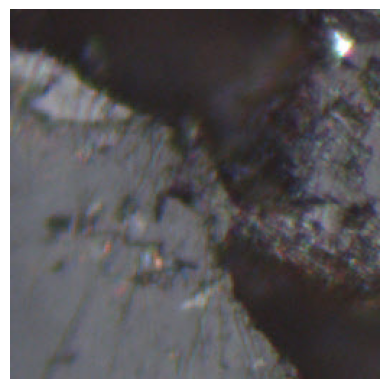

In [ ]:


# Load the image
image_path = '/content/patches/patch_0.png'  # Replace with your image path
image = Image.open(image_path)

# Convert the image to a NumPy array
image_array = np.array(image)

# Print the shape and type of the array to verify
print("Shape of the image array:", image_array.shape)
print("Data type of the image array:", image_array.dtype)

# Optionally, display the image using matplotlib (if you want to visualize it)
import matplotlib.pyplot as plt

plt.imshow(image_array)
plt.axis('off')  # Hide axes
plt.show()


In [ ]:
image = Image.open("/content/patches/patch_0.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape




(256, 256, 3)

In [ ]:
image = Image.open("/content/image_patches/im000.png")  # Replace "your_image.jpg" with the path to your JPG image
image_array = np.array(image)
image_array.shape

(256, 256, 3)

In [ ]:
image_array=np.load("/content/segmented_patches/seg_patch0.npy")
print(image_array)

[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 0 0]]
